<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**Chatbot Modelling**

*Authors (alphabetical) : Khumalo, Michael, Robinson, Curtis, Tosun, Tolga, Wan, Chi Chuen (Edmond), Zhang, Guizhen (Jane)*

- Exploratory Data Analysis
- Data Processing for SeqtoSeq Model
- Model Architecture without Attention
  - Define Encoder, Decoder, SeqtoSeq Models
  - Training
  - Evaluation
- Model Architecture with Attention
  - Define Attention Mechanism
  - Define Encoder, Decoder, SeqtoSeq Models
  - Training
  - Evaluation
- Model Tuning
....

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**Exploratory Data Analysis**
- Set-up environment
- Load libraries
- Load datasets
- Data exploration

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import numpy as np
import seaborn as sns
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Layer, Embedding, GRU, Dense, Bidirectional, Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
# Checking GPU availablibility
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    for gpu in gpus:
        print("Found a GPU with the name:", gpu)
else:
    print("Failed to detect a GPU.")

Failed to detect a GPU.


In [2]:
# Load datasets
train_data_path = 'WikiQA-train.tsv'
dev_data_path = 'WikiQA-dev.tsv'
test_data_path = 'WikiQA-test.tsv'

train_data = pd.read_csv(train_data_path, sep='\t', encoding='utf-8')
dev_data = pd.read_csv(dev_data_path, sep='\t', encoding='utf-8')
test_data = pd.read_csv(test_data_path, sep='\t', encoding='utf-8')

train_data.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q1,how are glacier caves formed?,D1,Glacier cave,D1-0,A partly submerged glacier cave on Perito More...,0
1,Q1,how are glacier caves formed?,D1,Glacier cave,D1-1,The ice facade is approximately 60 m high,0
2,Q1,how are glacier caves formed?,D1,Glacier cave,D1-2,Ice formations in the Titlis glacier cave,0
3,Q1,how are glacier caves formed?,D1,Glacier cave,D1-3,A glacier cave is a cave formed within the ice...,1
4,Q1,how are glacier caves formed?,D1,Glacier cave,D1-4,"Glacier caves are often called ice caves , but...",0


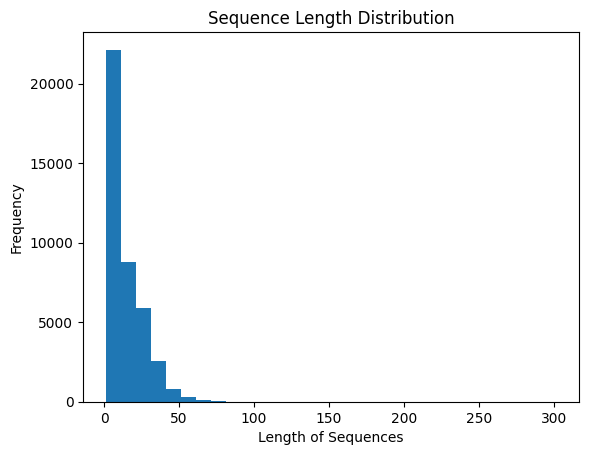

In [3]:
texts = train_data['Question'].tolist() + train_data['Sentence'].tolist()
# Check sequence length
sequence_lengths = [len(text.split()) for text in texts]
plt.hist(sequence_lengths, bins=30)
plt.title('Sequence Length Distribution')
plt.xlabel('Length of Sequences')
plt.ylabel('Frequency')
plt.show()

In [4]:
# Check unique words
word_counts = Counter(word for text in texts for word in text.split())
print("Total unique words:", len(word_counts))

Total unique words: 57622


In [5]:
train_data.pivot_table(index=[f'Question'], aggfunc='count')

,DocumentID,DocumentTitle,Label,QuestionID,Sentence,SentenceID
Question,,,,,,
HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840'S,9,9,9,9,9,9
HOW MANY STRIPES ARE ON THE AMERICAN FLAG,3,3,3,3,3,3
How Did Paul Bragg Die,1,1,1,1,1,1
How Do You Find the mean of the squares of the first 10 counting numbers,12,12,12,12,12,12
How Do You Get Hepatitis C,13,13,13,13,13,13
...,...,...,...,...,...,...
who wrote the song cocaine,5,5,5,5,5,5
who wrote the song feelin alright,6,6,6,6,6,6
who wrote the song in the mood,3,3,3,3,3,3


In [6]:
train_data.pivot_table(index=[f'Question'], aggfunc='size')

Question
HOW MANY BROTHELS WERE THERE IN THE UNITED STATES IN 1840'S                  9
HOW MANY STRIPES ARE ON THE AMERICAN FLAG                                    3
How Did Paul Bragg Die                                                       1
How Do You Find the mean of the squares of the first 10 counting numbers    12
How Do You Get Hepatitis C                                                  13
                                                                            ..
who wrote the song cocaine                                                   5
who wrote the song feelin alright                                            6
who wrote the song in the mood                                               3
who wrote what's my name rihanna                                            11
who wrote white christmas                                                    7
Length: 2117, dtype: int64

In [7]:
# Check common words
def word_count(text_series):
    counts = Counter()
    for i in text_series:
        counts.update(i.split())
    return counts

question_words = word_count(train_data['Question'])
answer_words = word_count(train_data['Sentence'])

print(f'Top 10 common words in Question', question_words.most_common(10))
print(f'Top 10 common words in Answer', answer_words.most_common(10))

Top 10 common words in Question [('what', 9201), ('the', 8473), ('is', 6993), ('in', 4021), ('how', 3999), ('of', 3300), ('who', 2348), ('was', 2238), ('are', 2102), ('did', 2056)]
Top 10 common words in Answer [('the', 28792), ('of', 17054), ('and', 14188), ('in', 10683), ('a', 9045), (',', 8596), ('to', 8317), ('is', 6857), ('.', 5217), ('The', 4996)]


In [8]:
# Change data into string
train_data['Question'] = train_data['Question'].astype(str)
train_data['Sentence'] = train_data['Sentence'].astype(str)

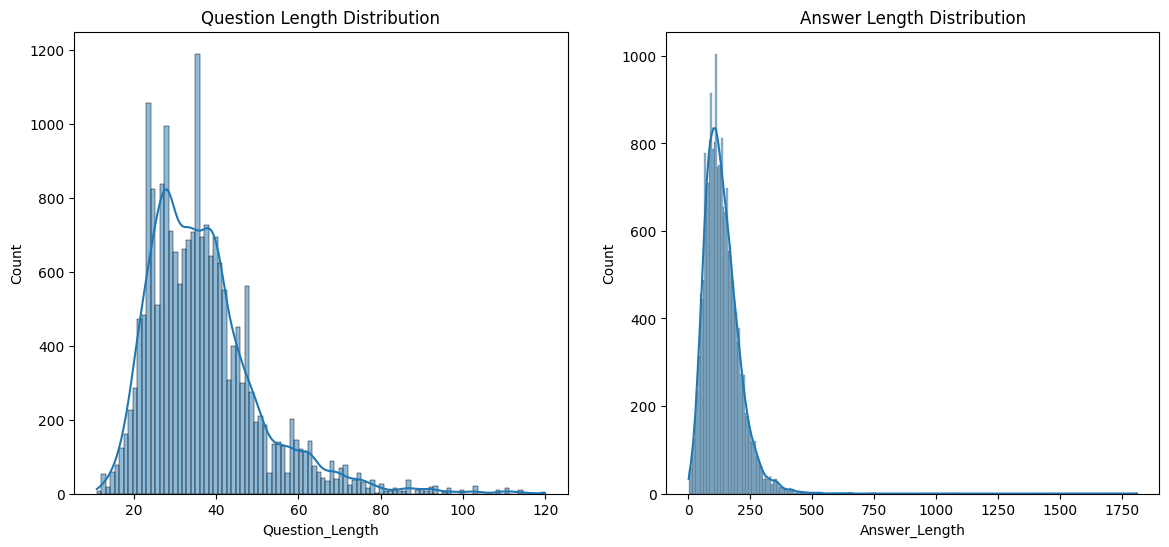

In [9]:
# Sequences length distribution
train_data['Question_Length'] = train_data['Question'].apply(len)
train_data['Answer_Length'] = train_data['Sentence'].apply(len)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_data['Question_Length'], kde=True)
plt.title('Question Length Distribution')

plt.subplot(1, 2, 2)
sns.histplot(train_data['Answer_Length'], kde=True)
plt.title('Answer Length Distribution')
plt.show()

In [10]:
df_QA_longlength = train_data[(train_data['Question_Length'] > 200) | (train_data['Answer_Length'] > 200)]

print(df_QA_longlength.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3152 entries, 9 to 20343
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   QuestionID       3152 non-null   object
 1   Question         3152 non-null   object
 2   DocumentID       3152 non-null   object
 3   DocumentTitle    3152 non-null   object
 4   SentenceID       3152 non-null   object
 5   Sentence         3152 non-null   object
 6   Label            3152 non-null   int64 
 7   Question_Length  3152 non-null   int64 
 8   Answer_Length    3152 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 246.2+ KB
None


In [11]:
# Sentiment analysis
def sentiment(text):
    return TextBlob(text).sentiment.polarity

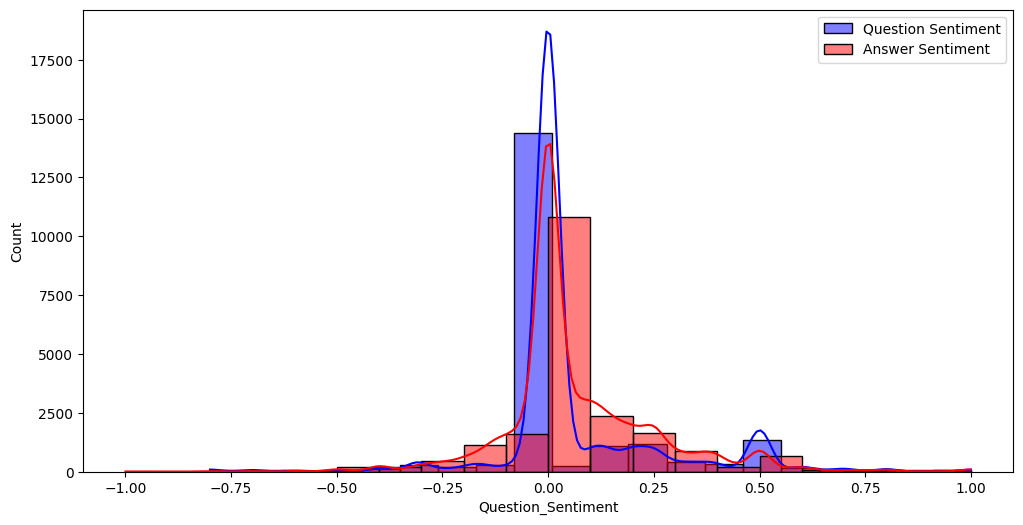

In [12]:
train_data['Question_Sentiment'] = train_data['Question'].apply(sentiment)
train_data['Answer_Sentiment'] = train_data['Sentence'].apply(sentiment)

plt.figure(figsize=(12, 6))
sns.histplot(train_data['Question_Sentiment'], bins=20, kde=True, color='blue', label='Question Sentiment')
sns.histplot(train_data['Answer_Sentiment'], bins=20, kde=True, color='red', label='Answer Sentiment')
plt.legend()
plt.show()

In [ ]:
df_QA_highlowscore = train_data[(train_data['Question_Sentiment'] >= 0.5) | (train_data['Question_Sentiment'] <= -0.5) | (train_data['Answer_Sentiment'] >= 0.5) | (train_data['Answer_Sentiment'] <= -0.5)]

print(df_QA_highlowscore.info())

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**Data Processing for SeqtoSeq Model**

In [54]:
class ChatbotPreprocessor:
    def __init__(self, max_len=50, num_words=10000, oov_token="<UNK>", sos_token="<SOS>", eos_token="<EOS>", pad_token="<PAD>"):
        self.max_len = max_len
        self.num_words = num_words
        self.oov_token = oov_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.tokenizer = Tokenizer(num_words=self.num_words, oov_token=oov_token)
        self.index_word = {}  # Initialize the reverse lookup dictionary

    def fit(self, texts):
        # Append and prepend special tokens to texts
        texts = [self.sos_token + " " + text + " " + self.eos_token for text in texts]
        self.tokenizer.fit_on_texts(texts)

        # Reserve indices for special tokens with their respective fixed indices
        special_tokens = {
            self.pad_token: 0,
            self.sos_token: 1,
            self.eos_token: 2,
            self.oov_token: 3
        }

        # Calculate word frequencies from tokenizer's internal dictionary
        word_counts = self.tokenizer.word_counts

        # Filter out words that appear less than 3 times
        filtered_words = {word: count for word, count in word_counts.items() if count >= 3 and word not in special_tokens.keys()}

        # Adjust word_index and reserve indices for special tokens
        updated_word_index = {}
        current_index = max(special_tokens.values()) + 1  # Start indices after special tokens
        for word in filtered_words:
            updated_word_index[word] = current_index
            current_index += 1

        # Include special tokens last to ensure their fixed positions
        updated_word_index.update(special_tokens)

        # Trim the dictionary to respect the num_words limit
        self.tokenizer.word_index = {word: idx for word, idx in sorted(updated_word_index.items(), key=lambda item: item[1]) if idx < self.num_words + len(special_tokens)}

        # Rebuild index_word from the updated word_index
        self.index_word = {idx: word for word, idx in self.tokenizer.word_index.items()}

    def transform(self, texts, is_target=False):
        sequences = self.tokenizer.texts_to_sequences(texts)
        if is_target:
            sequences = [[self.tokenizer.word_index[self.sos_token]] + seq + [self.tokenizer.word_index[self.eos_token]] for seq in sequences]

        pad_value = self.tokenizer.word_index[self.pad_token]
        padded_sequences = pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post', value=pad_value)
        return padded_sequences

    def prepare_data(self, df, is_train=False):
        if is_train:
            texts = df['Question'].tolist() + df['Sentence'].tolist()
            self.fit(texts)

        question_seqs = self.transform(df['Question'].tolist())
        answer_seqs = self.transform(df['Sentence'].tolist(), is_target=True)
        return question_seqs, answer_seqs

    def index_to_word(self, index):
        return self.index_word.get(index, None)

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**Model Architecture without Attention**
- Define Encoder, Decoder, SeqtoSeq Models
- Training
- Evaluation

In [15]:
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(enc_units, return_state=True)

    def call(self, x):
        x = self.embedding(x)
        output, state = self.gru(x)
        return state

In [16]:
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()

        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(dec_units, return_sequences=True, return_state=True)
        self.dense = Dense(vocab_size, activation='softmax')

    def call(self, x, state):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=state)
        output = self.dense(output)
        return output, state

In [17]:
def build_seq2seq_model(vocab_size, embedding_dim, units):
    # Define inputs
    encoder_inputs = Input(shape=(None,))
    decoder_inputs = Input(shape=(None,))

    # Create encoder and decoder
    encoder = Encoder(vocab_size, embedding_dim, units)
    decoder = Decoder(vocab_size, embedding_dim, units)

    # Connect encoder and decoder
    encoder_state = encoder(encoder_inputs)
    decoder_outputs, _ = decoder(decoder_inputs, encoder_state)

    # Complete model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [18]:
preprocessor = ChatbotPreprocessor(max_len=50, num_words=13000)

In [19]:
# Prepare training data
input_train, target_train = preprocessor.prepare_data(train_data, is_train=True)

In [20]:
# Reshape data ready for training
decoder_input_train = np.hstack([np.ones((target_train.shape[0], 1)), target_train[:, :-1]])
decoder_output_train = np.expand_dims(target_train, -1)

In [21]:
# Prepare validation data
input_val, target_val = preprocessor.prepare_data(dev_data, is_train=False)
decoder_input_val = np.hstack([np.ones((target_val.shape[0], 1)), target_val[:, :-1]])
decoder_output_val = np.expand_dims(target_val, -1)

In [22]:
# Build model
seq2seq_model = build_seq2seq_model(vocab_size=len(preprocessor.tokenizer.word_index) + 1, embedding_dim=256, units=512)
seq2seq_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 encoder (Encoder)           (None, 512)                  4512000   ['input_1[0][0]']             
                                                                                                  
 decoder (Decoder)           ((None, None, 13005),        1118356   ['input_2[0][0]',             
                              (None, 512))                5          'encoder[0][0]']         

In [23]:
# Tracking training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [25]:
# Train the model
history = seq2seq_model.fit(
    [input_train, decoder_input_train],
    decoder_output_train,
    batch_size=62,
    epochs=10,
    validation_data=([input_val, decoder_input_val], decoder_output_val),
    callbacks=[early_stopping]
)

Epoch 1/10
329/329 [==============================] - 29s 88ms/step - loss: 2.1441 - accuracy: 0.6505 - val_loss: 2.3420 - val_accuracy: 0.6511
Epoch 2/10
329/329 [==============================] - 29s 89ms/step - loss: 1.9640 - accuracy: 0.6626 - val_loss: 2.3324 - val_accuracy: 0.6527
Epoch 3/10
329/329 [==============================] - 28s 86ms/step - loss: 1.7899 - accuracy: 0.6770 - val_loss: 2.3303 - val_accuracy: 0.6547
Epoch 4/10
329/329 [==============================] - 29s 88ms/step - loss: 1.6267 - accuracy: 0.6941 - val_loss: 2.3389 - val_accuracy: 0.6568
Epoch 5/10
329/329 [==============================] - 29s 88ms/step - loss: 1.4784 - accuracy: 0.7128 - val_loss: 2.3537 - val_accuracy: 0.6568
Epoch 6/10
329/329 [==============================] - 29s 88ms/step - loss: 1.3483 - accuracy: 0.7314 - val_loss: 2.3736 - val_accuracy: 0.6577
Epoch 7/10
329/329 [==============================] - 29s 87ms/step - loss: 1.2333 - accuracy: 0.7491 - val_loss: 2.3973 - val_accuracy:

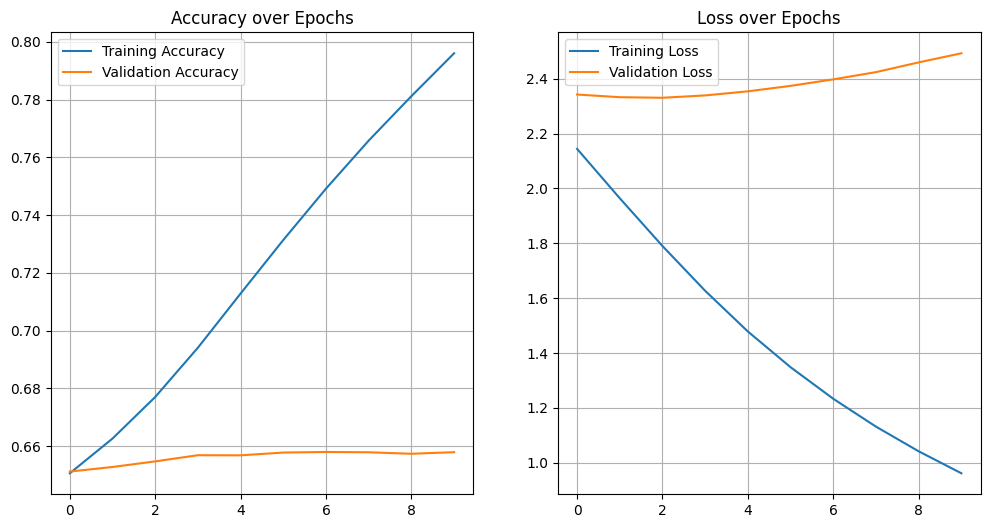

In [26]:
# Disply training flow
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.show()

In [27]:
trained_model = seq2seq_model

In [28]:
# Prepare test data
input_test, target_test = preprocessor.prepare_data(test_data, is_train=False)

# Choose a subset of the test data
num_samples = 100
input_test_subset = input_test[:num_samples]
target_test_subset = target_test[:num_samples]

decoder_input_test_subset = np.hstack([np.ones((num_samples, 1)), target_test_subset[:, :-1]])  # start tokens
decoder_output_test_subset = np.expand_dims(target_test_subset, -1)

In [29]:
predictions = trained_model.predict([input_test_subset, decoder_input_test_subset])

4/4 [==============================] - 1s 19ms/step


In [31]:
predicted_sentences = []
for prediction in predictions:
    predicted_sentence = []
    for token_probs in prediction:

        predicted_token_index = np.random.choice(len(token_probs), p=token_probs)
        if predicted_token_index == preprocessor.tokenizer.word_index['<EOS>']:
            break
        predicted_word = preprocessor.tokenizer.index_word.get(predicted_token_index, '<OOV>')
        predicted_sentence.append(predicted_word)
    predicted_sentences.append(' '.join(predicted_sentence))

In [32]:
predicted_sentences[:10]

['<UNK> with each new 2002 handled history personal new to refers knowles each history to did reproduce bus fourteen located to does <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>',
 '<UNK> to court name republic early residential as jobs bear did new to to knowles relation moving hurricane to baptist does <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>',
 '<UNK> to broadcasting history new to to did plot are sets sox discussion activism bounds design now name to army portion wartime well tablespoon eos early history popularity does tinted ever portion portion married officer',
 "<UNK> to republic well produced ' history in refers courts new winter rna to are saint industrial score who court considered testament <OOV> <OOV> <OOV> <OOV> <OOV> <

<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>

**Model Architecture with Attention**
- Define Attention Mechanism
- Define Encoder, Decoder, SeqtoSeq Models
- Training
- Evaluation

In [33]:
class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, query, values):

        query_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [34]:
class Encoder(Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(enc_units, return_sequences=True, return_state=True)

    def call(self, x):
        x = self.embedding(x)
        output, state = self.gru(x)
        return output, state

In [35]:
class Decoder(Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.embedding = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(dec_units, return_sequences=True, return_state=True)
        self.dense = Dense(vocab_size, activation='softmax')
        self.attention = BahdanauAttention(dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        context_vector = tf.expand_dims(context_vector, 1)
        context_vector = tf.tile(context_vector, [1, tf.shape(x)[1], 1])

        x = tf.concat([context_vector, x], axis=-1)

        output, state = self.gru(x, initial_state=hidden)

        output = self.dense(output)

        return output, state, attention_weights

In [36]:
def build_attention_seq2seq_model(vocab_size, embedding_dim, units):
    encoder_inputs = Input(shape=(None,))
    decoder_inputs = Input(shape=(None,))

    encoder = Encoder(vocab_size, embedding_dim, units)
    decoder = Decoder(vocab_size, embedding_dim, units)

    enc_output, encoder_state = encoder(encoder_inputs)  # Get both outputs and final state
    decoder_outputs, decoder_state, attention_weights = decoder(decoder_inputs, encoder_state, enc_output)  # Pass enc_output to decoder

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [37]:
# Build and compile the model
attention_seq2seq_model = build_attention_seq2seq_model(vocab_size=len(preprocessor.tokenizer.word_index) + 1, embedding_dim=256, units=512)
attention_seq2seq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
attention_seq2seq_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 encoder_1 (Encoder)         ((None, None, 512),          4512000   ['input_3[0][0]']             
                              (None, 512))                                                        
                                                                                                  
 decoder_1 (Decoder)         ((None, None, 13005),        1249582   ['input_4[0][0]',       

In [38]:
# Track the training flow
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [39]:
history = attention_seq2seq_model.fit(
    [input_train, decoder_input_train],
    decoder_output_train,
    batch_size=62,
    epochs=10,
    validation_data=([input_val, decoder_input_val], decoder_output_val),
    callbacks=[early_stopping]
)

Epoch 1/10
329/329 [==============================] - 49s 134ms/step - loss: 3.4142 - accuracy: 0.5680 - val_loss: 2.9640 - val_accuracy: 0.6027
Epoch 2/10
329/329 [==============================] - 32s 97ms/step - loss: 3.1112 - accuracy: 0.5941 - val_loss: 2.9030 - val_accuracy: 0.6116
Epoch 3/10
329/329 [==============================] - 31s 95ms/step - loss: 3.0628 - accuracy: 0.5988 - val_loss: 2.8810 - val_accuracy: 0.6137
Epoch 4/10
329/329 [==============================] - 31s 95ms/step - loss: 2.9787 - accuracy: 0.6022 - val_loss: 2.7418 - val_accuracy: 0.6209
Epoch 5/10
329/329 [==============================] - 31s 96ms/step - loss: 2.7663 - accuracy: 0.6165 - val_loss: 2.5765 - val_accuracy: 0.6347
Epoch 6/10
329/329 [==============================] - 32s 98ms/step - loss: 2.5594 - accuracy: 0.6281 - val_loss: 2.4877 - val_accuracy: 0.6400
Epoch 7/10
329/329 [==============================] - 32s 96ms/step - loss: 2.3708 - accuracy: 0.6358 - val_loss: 2.4387 - val_accuracy

In [40]:
# Evaluate with test data
attention_predictions = attention_seq2seq_model.predict([input_test_subset, decoder_input_test_subset])

4/4 [==============================] - 1s 21ms/step


In [41]:
predicted_sentences = []
for prediction in attention_predictions:
    predicted_sentence = []
    for token_probs in prediction:

        predicted_token_index = np.random.choice(len(token_probs), p=token_probs)
        if predicted_token_index == preprocessor.tokenizer.word_index['<EOS>']:
            break
        predicted_word = preprocessor.tokenizer.index_word.get(predicted_token_index, '<OOV>')
        predicted_sentence.append(predicted_word)
    predicted_sentences.append(' '.join(predicted_sentence))

In [48]:
predicted_sentences[:10]

['<UNK> die cocoa exercise degree scheduled history having new who penalties ata decatherms history as costs calorimeter to determines new to well <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>',
 '<UNK> spans conservation 23 mermaid look early eos embryo in upon new to physics latin views with storms prevent mighty pump <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>',
 "<UNK> to illustration says solstice green among as irwin's eos meiosis presided reddish suicide portion to now learning contacted love portion",
 '<UNK> diagnosis republic well seen originally historical 15 personal accurate test jean as to security eos to among to result intervene located <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OO

In [53]:
def generate_reply(model, preprocessor, input_question, max_length=50, temperature=1.0):
    # Preprocess the input question
    preprocessed_question = input_question

    # Encode the preprocessed question
    input_sequence = preprocessor.transform([preprocessed_question])

    # Prepare initial decoder input with start-of-sequence token
    decoder_input = np.array([[preprocessor.tokenizer.word_index[preprocessor.sos_token]]])

    # Initialize the generated answer
    generated_answer = []

    # Perform inference
    for _ in range(max_length):
        # Predict the next token
        predictions = model.predict([input_sequence, decoder_input])

        # Apply temperature to the predictions to control the randomness
        predictions = np.log(predictions) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        # Sample from the probability distribution
        predicted_index = np.random.choice(len(predictions[0, -1, :]), p=predictions[0, -1, :])

        # If the predicted token is the end-of-sequence token, stop
        if predicted_index == preprocessor.tokenizer.word_index[preprocessor.eos_token]:
            break

        # Convert the predicted index to text and add to the generated answer
        predicted_word = preprocessor.tokenizer.index_word.get(predicted_index, preprocessor.oov_token)
        generated_answer.append(predicted_word)

        # Update the decoder input for the next timestep
        decoder_input = np.array([[predicted_index]])

    # Concatenate the generated answer tokens to form the reply
    generated_answer_text = ' '.join(generated_answer)

    return generated_answer_text

# Example usage
input_question = "how big is the purdue greek system?"
reply = generate_reply(attention_seq2seq_model, preprocessor, input_question)
print("Model Reply:", reply)

1/1 [==============================] - 0s 20ms/step
Model Reply: <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>


<div style="border-top: 7px solid #800080; animation: sparkling 2s linear infinite;"></div>

<style>
@keyframes sparkling {
  0% { background-position: 0 0; }
  100% { background-position: 100% 0; }
}
</style>